# S06-demo-02 – Bagging и Random Forest

Этот ноутбук – про **ансамбли деревьев**: как из “слабого” и шумного предсказателя сделать **устойчивую** модель за счёт идеи *много моделей лучше одной*.

После прохождения вы должны уметь:

- объяснить, что такое **bootstrap** и почему это важно для bagging;
- различать **одно дерево**, **bagging** и **random forest** (в чём добавляется случайность и зачем);
- понимать идею **variance** (разброс результата) и как ансамбли её уменьшают;
- знать, что такое **OOB-score** (out-of-bag) и где он полезен;
- интерпретировать базовые **важности признаков** (быстрая эвристика и permutation importance).

**Как работать с ноутбуком:** запускайте ячейки по порядку, а перед каждым блоком кода попробуйте **сформулировать ожидание** – что должно измениться и почему.


## 0. Импорты и вспомогательные функции

Мы используем `scikit-learn` и `matplotlib`.

Дальше в ноутбуке будут три “служебные” вещи:

1) функция `print_metrics(...)` – печатает несколько метрик (accuracy, F1 и иногда ROC-AUC) и матрицу ошибок;  
2) функция `plot_decision_boundary(...)` – рисует границу решений в 2D (по двум признакам);  
3) небольшая обёртка `make_bagging_tree(...)` – это техническая совместимость: в разных версиях `scikit-learn` параметр в `BaggingClassifier` назывался по‑разному (`estimator` vs `base_estimator`).

**Важно:** дальше мы фиксируем `RANDOM_STATE`, чтобы результаты были воспроизводимыми.


In [1]:
# Импорты и базовые настройки
# - numpy: численные операции
# - matplotlib: визуализации
# - sklearn: датасеты, модели и метрики
#
# RANDOM_STATE фиксируем для воспроизводимости: один и тот же seed → одинаковые разбиения и результаты.

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons, load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.inspection import permutation_importance

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [2]:
# Вспомогательные функции для демо
# - print_metrics: печать набора метрик + confusion matrix
# - plot_decision_boundary: визуализация границы решений в 2D (только для задач с 2 признаками)
# - make_bagging_tree: совместимость sklearn (параметр estimator/base_estimator в разных версиях)
#
# Эти функции не “магия”, а просто удобные обёртки, чтобы дальше концентрироваться на идеях ансамблей.

def print_metrics(y_true, y_pred, y_proba=None, title=None):
    if title:
        print(title)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"accuracy = {acc:.4f}")
    print(f"f1       = {f1:.4f}")
    if y_proba is not None:
        try:
            auc = roc_auc_score(y_true, y_proba)
            print(f"roc_auc  = {auc:.4f}")
        except Exception:
            pass
    print("confusion_matrix:")
    print(confusion_matrix(y_true, y_pred))
    print()

def plot_decision_boundary_2d(model, X, y, title=None, steps=300):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, steps),
                         np.linspace(y_min, y_max, steps))
    grid = np.c_[xx.ravel(), yy.ravel()]
    zz = model.predict(grid).reshape(xx.shape)

    plt.figure(figsize=(7, 5))
    plt.contourf(xx, yy, zz, alpha=0.25)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=20)
    if title:
        plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.show()

def make_bagging_tree(estimator, n_estimators=200, random_state=42, oob_score=True, n_jobs=-1):
    # совместимость с разными версиями sklearn
    try:
        return BaggingClassifier(
            estimator=estimator,
            n_estimators=n_estimators,
            bootstrap=True,
            oob_score=oob_score,
            n_jobs=n_jobs,
            random_state=random_state
        )
    except TypeError:
        return BaggingClassifier(
            base_estimator=estimator,
            n_estimators=n_estimators,
            bootstrap=True,
            oob_score=oob_score,
            n_jobs=n_jobs,
            random_state=random_state
        )

## 1. Bootstrap-интуиция: почему из 100% объектов остаётся ~63% уникальных

**Bagging** (bootstrap aggregating) строит много моделей на “псевдо-выборках”, полученных из исходной обучающей выборки с помощью **bootstrap**: мы случайно выбираем объекты **с возвращением**.

Что это даёт:

- часть объектов попадёт **несколько раз** (дубли);
- часть объектов **не попадёт вообще**;
- каждая модель видит “свою” версию данных → ошибки разных моделей становятся менее синхронными.

Классический факт: если из `N` объектов выбирать `N` раз с возвращением, то ожидаемая доля **уникальных** объектов будет около:

- `1 - (1 - 1/N)^N ≈ 1 - e^{-1} ≈ 0.632` → **63.2%**.

То есть примерно **36.8%** объектов окажутся “за бортом” конкретной bootstrap-выборки – и это как раз то, что потом используется в **OOB-оценке**.

**Самопроверка:** почему bagging особенно помогает моделям с высокой дисперсией (например, глубоким деревьям)?


Средняя доля уникальных объектов: 0.632
Минимум/максимум: 0.605 / 0.653


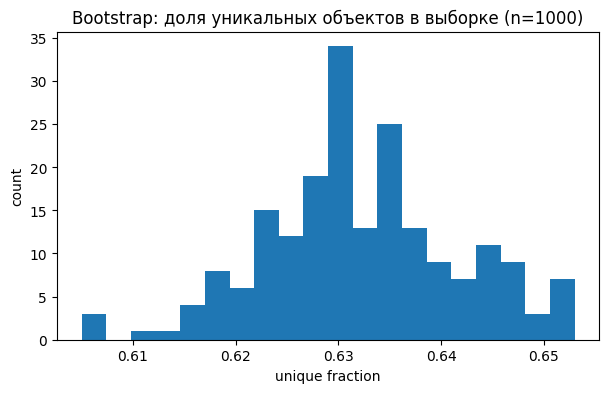

In [3]:
# Bootstrap на пальцах: эмпирически проверим долю уникальных объектов
# Мы много раз делаем bootstrap-выборку размера N из N (с возвращением)
# и смотрим, какая доля объектов оказалась уникальной.
#
# Ожидание: средняя доля уникальных ≈ 63.2% (остальные – дубли), и это не зависит от N (при больших N).

n = 1000
trials = 200

uniq_frac = []
for _ in range(trials):
    idx = np.random.randint(0, n, size=n)  # bootstrap sample, size=n
    uniq_frac.append(len(np.unique(idx)) / n)

print(f"Средняя доля уникальных объектов: {np.mean(uniq_frac):.3f}")
print(f"Минимум/максимум: {np.min(uniq_frac):.3f} / {np.max(uniq_frac):.3f}")

plt.figure(figsize=(7, 4))
plt.hist(uniq_frac, bins=20)
plt.xlabel("unique fraction")
plt.ylabel("count")
plt.title("Bootstrap: доля уникальных объектов в выборке (n=1000)")
plt.show()

## 2. Сравнение на 2D-датасете (make_moons)

Возьмём `make_moons`: всего два признака → можно **увидеть** границу решений глазами.

Мы будем сравнивать три модели:

1) одиночное дерево решений (как базовый ориентир);
2) bagging из деревьев;
3) random forest.

Сначала фиксируем train/test split, чтобы сравнение было честным.


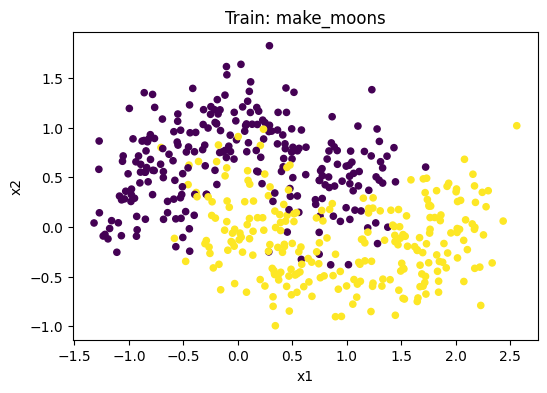

In [4]:
# Генерируем 2D-датасет и делаем train/test split
# make_moons: два “полумесяца” → нелинейная граница решений
# noise добавляет шум: задача становится более реалистичной и лучше видно переобучение/variance.

X, y = make_moons(n_samples=700, noise=0.28, random_state=RANDOM_STATE)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y
)

plt.figure(figsize=(6, 4))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=20)
plt.title("Train: make_moons")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

### 2.1. Одиночное дерево (высокая дисперсия)

Дерево решений легко “подстраивается” под данные. Если не ограничивать глубину, оно часто:

- даёт очень сложную границу решений;
- хорошо объясняет обучающую выборку,
- но может хуже обобщать на новых данных (особенно при шуме).

Это типичный пример **высокой дисперсии (variance)**: небольшой сдвиг в данных или `random_state` → заметно другой результат.

Перед запуском кода попробуйте предсказать:  
какой будет граница решений – “гладкая” или “рваная”?


DecisionTree – test
accuracy = 0.8905
f1       = 0.8940
confusion_matrix:
[[90 15]
 [ 8 97]]



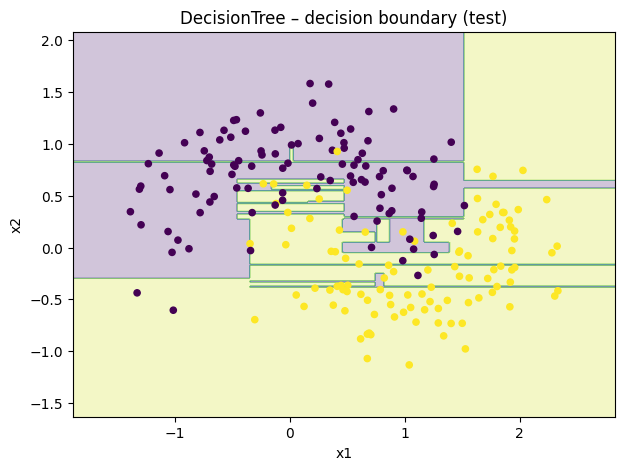

In [5]:
# 1) Одиночное дерево решений
# Здесь дерево по умолчанию может стать достаточно “глубоким” и построить очень сложную границу.
# Это хорошо показывает идею высокой дисперсии: модель легко меняется при небольших изменениях данных.

tree = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=None)
tree.fit(X_train, y_train)

print_metrics(y_test, tree.predict(X_test), title="DecisionTree – test")
plot_decision_boundary_2d(tree, X_test, y_test, title="DecisionTree – decision boundary (test)")

### 2.2. Bagging деревьев: “правило толпы”

**Bagging** строит много моделей на bootstrap-выборках и агрегирует ответы (для классификации – обычно голосование).

Интуиция:

- если отдельные деревья шумные и переобучаются, то усреднение/голосование “сглаживает” ошибки;
- качество становится более **стабильным**.

Параметры, на которые стоит смотреть:

- `n_estimators` – сколько деревьев в ансамбле (больше → стабильнее, но медленнее);
- `bootstrap=True` – включаем bootstrap;
- `oob_score=True` – попросим модель оценить себя “по объектам вне bootstrap” (про это ниже).

Перед запуском кода:  
ожидаете ли вы, что граница станет более гладкой по сравнению с одиночным деревом?


Bagging oob_score_ = 0.8959183673469387
Bagging(DecisionTree) – test
accuracy = 0.9095
f1       = 0.9116
confusion_matrix:
[[93 12]
 [ 7 98]]



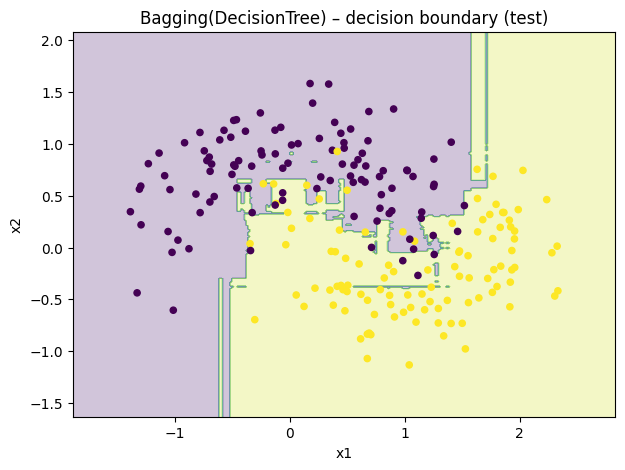

In [6]:
# 2) Bagging деревьев
# Идея: обучаем много деревьев на bootstrap-выборках и агрегируем ответы (голосованием).
# Ожидаемый эффект: качество становится более стабильным, граница решений – более “сглаженной”.
#
# base_tree – базовый алгоритм (отдельное дерево), вокруг него строим ансамбль BaggingClassifier.

base_tree = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=None)

bag = make_bagging_tree(base_tree, n_estimators=250, random_state=RANDOM_STATE, oob_score=True, n_jobs=-1)
bag.fit(X_train, y_train)

print(f"Bagging oob_score_ = {getattr(bag, 'oob_score_', None)}")
print_metrics(y_test, bag.predict(X_test), title="Bagging(DecisionTree) – test")
plot_decision_boundary_2d(bag, X_test, y_test, title="Bagging(DecisionTree) – decision boundary (test)")

### 2.3. Random Forest: bagging + случайность по признакам

**Random Forest** делает всё то же, что bagging, но добавляет ещё один источник разнообразия:

- на каждом разбиении дерева рассматривается **случайное подмножество признаков**.

Зачем это нужно:

- деревья в bagging могут быть сильно **коррелированы** (особенно если есть “очень сильный” признак);
- случайность по признакам уменьшает корреляцию деревьев → ансамбль становится ещё сильнее.

Ключевые параметры:

- `n_estimators` – число деревьев;
- `max_features` – сколько признаков пробовать на каждом split;
- `max_depth` / `min_samples_leaf` – ограничения сложности (можно использовать как регуляризацию).

Перед запуском:  
как вы думаете, будет ли random forest ещё устойчивее bagging?


RandomForest oob_score_ = 0.8714
RandomForest – test
accuracy = 0.9095
f1       = 0.9108
confusion_matrix:
[[94 11]
 [ 8 97]]



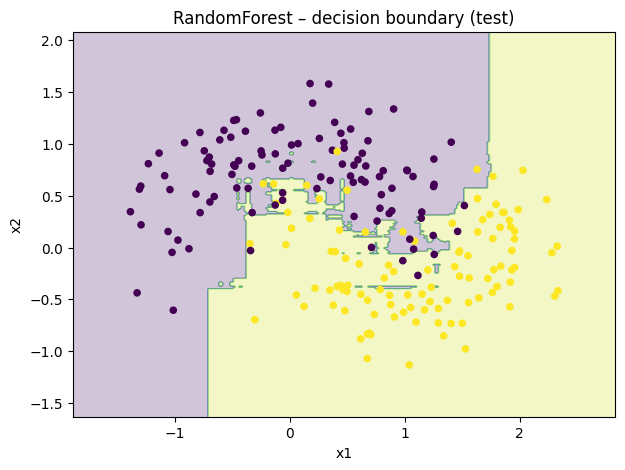

In [7]:
# 3) Random Forest
# Это bagging + дополнительная случайность по признакам на каждом разбиении.
# Смысл: уменьшить корреляцию между деревьями → усилить ансамбль.
#
# Обратите внимание на параметры:
# - n_estimators: сколько деревьев в лесу
# - max_features: сколько признаков пробовать на split (источник “feature randomness”)

rf = RandomForestClassifier(
    n_estimators=400,
    random_state=RANDOM_STATE,
    oob_score=True,
    n_jobs=-1,
    # max_features="sqrt"  # по умолчанию для классификации обычно sqrt(n_features)
)
rf.fit(X_train, y_train)

print(f"RandomForest oob_score_ = {rf.oob_score_:.4f}")
print_metrics(y_test, rf.predict(X_test), title="RandomForest – test")
plot_decision_boundary_2d(rf, X_test, y_test, title="RandomForest – decision boundary (test)")

## 3. Устойчивость: что будет при разных `random_state`

Инженерная проверка “на здравый смысл”:

- если модель сильно зависит от случайности, то при разных `random_state` метрики заметно “пляшут”;
- если модель устойчива, разброс будет меньше.

В этом блоке мы несколько раз переобучим модели, меняя seed, и сравним распределение метрик.

> Важно: это не заменяет корректную оценку (например, кросс-валидацию), но хорошо показывает **variance** наглядно.


In [8]:
# Сравнение устойчивости при разных random_state
# Мы многократно переобучаем каждую модель с разными seed и собираем метрики.
# Так видно, у какой модели variance больше (шире распределение качества).

seeds = list(range(0, 20))

acc_tree = []
acc_bag = []
acc_rf = []

for s in seeds:
    t = DecisionTreeClassifier(random_state=s, max_depth=None)
    t.fit(X_train, y_train)
    acc_tree.append(accuracy_score(y_test, t.predict(X_test)))

    b = make_bagging_tree(DecisionTreeClassifier(random_state=s, max_depth=None),
                          n_estimators=200, random_state=s, oob_score=False, n_jobs=-1)
    b.fit(X_train, y_train)
    acc_bag.append(accuracy_score(y_test, b.predict(X_test)))

    r = RandomForestClassifier(n_estimators=300, random_state=s, n_jobs=-1)
    r.fit(X_train, y_train)
    acc_rf.append(accuracy_score(y_test, r.predict(X_test)))

print(f"DecisionTree: mean={np.mean(acc_tree):.4f}, std={np.std(acc_tree):.4f}")
print(f"Bagging:      mean={np.mean(acc_bag):.4f}, std={np.std(acc_bag):.4f}")
print(f"RandForest:   mean={np.mean(acc_rf):.4f}, std={np.std(acc_rf):.4f}")

DecisionTree: mean=0.8888, std=0.0051
Bagging:      mean=0.9079, std=0.0041
RandForest:   mean=0.9086, std=0.0039


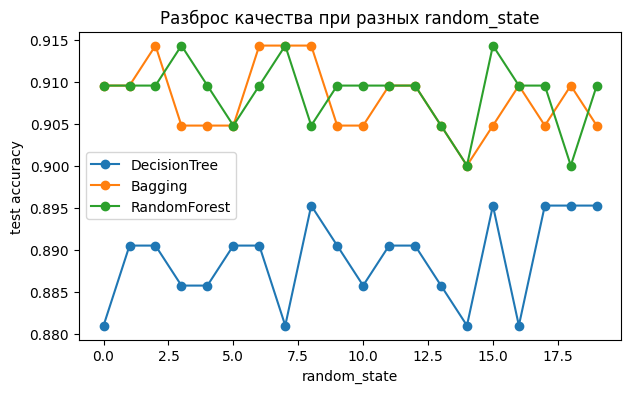

In [9]:
# Визуализация распределений метрик
# Здесь обычно удобно смотреть boxplot/violin: медиана и разброс.
# Чем уже “ящик”, тем стабильнее модель по отношению к случайности.

plt.figure(figsize=(7, 4))
plt.plot(seeds, acc_tree, marker="o", label="DecisionTree")
plt.plot(seeds, acc_bag, marker="o", label="Bagging")
plt.plot(seeds, acc_rf, marker="o", label="RandomForest")
plt.xlabel("random_state")
plt.ylabel("test accuracy")
plt.title("Разброс качества при разных random_state")
plt.legend()
plt.show()

Обычно получается такая картина:

- одиночное дерево даёт **заметный разброс** качества (особенно на шумных данных);
- bagging уменьшает разброс;
- random forest часто уменьшает разброс ещё сильнее.

**Что важно заметить:** ансамбли уменьшают variance за счёт усреднения и уменьшения корреляции между базовыми моделями.

Если у вас вышло иначе – это тоже нормально: на маленьких/простых данных или при других параметрах эффекты могут быть слабее. Главное – понять механизм.


## 4. OOB (Out-of-Bag): “оценка без отдельной валидации”

При bootstrap примерно **36.8%** объектов не попадает в конкретную bootstrap-выборку.  
Эти объекты можно использовать как “мини‑валидацию” для данного дерева.

**OOB-score** – это агрегированная оценка качества ансамбля по объектам, которые были “вне bootstrap” для каждого базового алгоритма.

Зачем это полезно:

- быстрый инженерный индикатор качества “на лету”;
- позволяет прикинуть, как модель будет обобщать, не выделяя отдельный валид‑набор.

Ограничения:

- это всё равно приближение, а не универсальная замена нормальному протоколу оценки;
- для тонкого тюнинга и отчётности лучше использовать hold-out/CV.


In [10]:
# OOB-score (Out-of-Bag)
# Для моделей с bootstrap можно оценивать качество без отдельного валид-набора:
# каждый объект “проверяется” теми деревьями, которые его НЕ видели при обучении.
#
# Мы просто печатаем oob_score_ для bagging и random forest (если включено oob_score=True).

print(f"Bagging oob_score_      = {getattr(bag, 'oob_score_', None)}")
print(f"RandomForest oob_score_ = {rf.oob_score_:.4f}")

print(f"Bagging test accuracy   = {accuracy_score(y_test, bag.predict(X_test)):.4f}")
print(f"RF test accuracy        = {accuracy_score(y_test, rf.predict(X_test)):.4f}")

Bagging oob_score_      = 0.8959183673469387
RandomForest oob_score_ = 0.8714
Bagging test accuracy   = 0.9095
RF test accuracy        = 0.9095


## 5. Мини-практика на табличном датасете (Breast Cancer)

На 2D‑картинке удобно смотреть границы, но в реальных задачах чаще табличные данные.

Здесь мы:

- обучим random forest на датасете `Breast Cancer` из `sklearn`;
- посмотрим метрики (accuracy/F1/ROC-AUC);
- посмотрим важности признаков двумя способами:
  - встроенная эвристика `feature_importances_`,
  - **permutation importance**.

**Важно:** ROC-AUC корректнее считать по вероятностям (`predict_proba`), а не по меткам классов.


In [11]:
# Переходим к табличным данным: Breast Cancer (sklearn)
# Это уже “реалистичнее”, чем 2D-картинка: много признаков, хочется посмотреть и метрики, и важности.
#
# Важный момент про метрики:
# - accuracy/F1 считаются по предсказанным классам
# - ROC-AUC корректнее считать по вероятностям положительного класса (predict_proba[:, 1])

data = load_breast_cancer()
X = data["data"]
y = data["target"]
feature_names = list(data["feature_names"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

tree_tab = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=None)
tree_tab.fit(X_train, y_train)

rf_tab = RandomForestClassifier(
    n_estimators=600,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    oob_score=True
)
rf_tab.fit(X_train, y_train)

proba_tree = tree_tab.predict_proba(X_test)[:, 1]
proba_rf = rf_tab.predict_proba(X_test)[:, 1]

print_metrics(y_test, (proba_tree >= 0.5).astype(int), y_proba=proba_tree, title="Tabular – DecisionTree")
print_metrics(y_test, (proba_rf >= 0.5).astype(int), y_proba=proba_rf, title="Tabular – RandomForest")
print(f"RandomForest oob_score_ = {rf_tab.oob_score_:.4f}")

Tabular – DecisionTree
accuracy = 0.9231
f1       = 0.9379
roc_auc  = 0.9234
confusion_matrix:
[[49  4]
 [ 7 83]]

Tabular – RandomForest
accuracy = 0.9580
f1       = 0.9670
roc_auc  = 0.9943
confusion_matrix:
[[49  4]
 [ 2 88]]

RandomForest oob_score_ = 0.9624


### 5.1. Быстрая важность: `feature_importances_`

`feature_importances_` в деревьях/лесах обычно основана на том, **насколько признак уменьшал impurity** (например, Gini) по всем разбиениям.

Плюсы:

- очень быстро считается “из коробки”;
- даёт первое приближение к пониманию модели.

Минусы/осторожность:

- может переоценивать признаки с большим числом уникальных значений/способов разбиения;
- показывает “внутримодельную” важность, а не обязательно причинный вклад.

Используйте это как **быструю диагностическую подсказку**, но не как окончательный вывод.


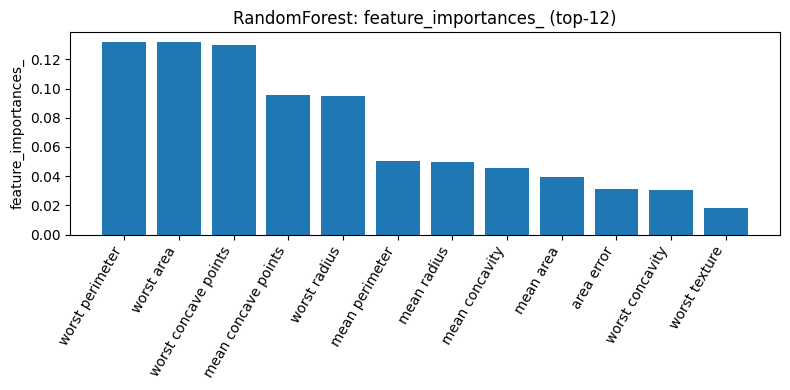

In [12]:
# Быстрая важность признаков (feature_importances_)
# Это встроенная эвристика леса: суммарный вклад признака в уменьшение impurity по всем деревьям.
# Полезно как диагностика, но помните про ограничения (см. markdown выше).

importances = rf_tab.feature_importances_
idx = np.argsort(importances)[::-1][:12]

plt.figure(figsize=(8, 4))
plt.bar(range(len(idx)), importances[idx])
plt.xticks(range(len(idx)), [feature_names[i] for i in idx], rotation=60, ha="right")
plt.ylabel("feature_importances_")
plt.title("RandomForest: feature_importances_ (top-12)")
plt.tight_layout()
plt.show()

### 5.2. Перестановочная важность (Permutation Importance)

**Permutation importance** измеряет влияние признака на качество так:

1) считаем качество на валидации/тесте;  
2) перемешиваем значения одного признака (ломаем связь с целевой переменной);  
3) снова считаем качество;  
4) падение качества ≈ важность признака.

Почему это полезно:

- метод ориентирован на качество модели (а не на внутреннюю эвристику дерева);
- часто даёт более “прикладную” интерпретацию.

Что помнить:

- при сильной корреляции признаков важности могут “размываться”;
- это вычислительно дороже (нужно много повторов `n_repeats`).

В этом блоке мы посчитаем permutation importance по ROC-AUC.


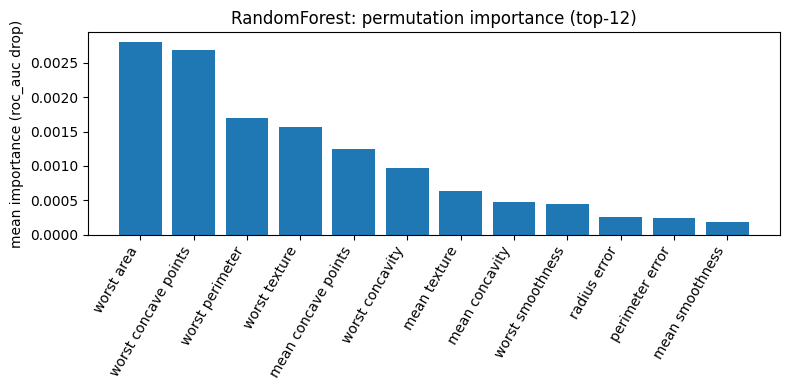

In [13]:
# Permutation importance
# Мы измеряем, насколько падает качество (ROC-AUC), если “сломать” признак:
# перемешать его значения на тесте и пересчитать метрику.
#
# n_repeats задаёт число повторов перемешивания для устойчивости оценки.

perm = permutation_importance(
    rf_tab, X_test, y_test,
    n_repeats=8,
    random_state=RANDOM_STATE,
    scoring="roc_auc"
)

pimp = perm.importances_mean
idx = np.argsort(pimp)[::-1][:12]

plt.figure(figsize=(8, 4))
plt.bar(range(len(idx)), pimp[idx])
plt.xticks(range(len(idx)), [feature_names[i] for i in idx], rotation=60, ha="right")
plt.ylabel("mean importance (roc_auc drop)")
plt.title("RandomForest: permutation importance (top-12)")
plt.tight_layout()
plt.show()

## 6. Выводы (коротко)

- **Bagging** уменьшает variance: много деревьев на bootstrap‑выборках → ответы усредняются → модель устойчивее.
- **Random Forest** добавляет случайность по признакам → деревья менее коррелированы → ансамбль обычно сильнее.
- **OOB-score** – удобная быстрая оценка качества для ансамблей на bootstrap, но для серьёзной оценки всё равно нужен корректный протокол (hold-out/CV).
- **Важность признаков** полезна как диагностика: сначала быстро (`feature_importances_`), затем надёжнее проверяем permutation importance.

Если вы хотите закрепить материал: попробуйте изменить `n_estimators`, `max_depth`, `max_features` и посмотрите, как меняются качество и устойчивость.
